In [243]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import uuid
import random
import pyspark.pandas as ps
from datetime import datetime, timedelta
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, regexp_extract, when, round, regexp_replace, sum, sequence, to_date, lit, row_number, weekofyear
from pyspark.sql.window import Window
from datetime import datetime, date, timedelta
from pyspark.sql.types import StringType, IntegerType, FloatType, ArrayType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, explode
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 4818-C6FC

 Directory of C:\Users\ariji\BDM_P2

19-05-2024  16:17    <DIR>          .
17-05-2024  01:33    <DIR>          ..
18-05-2024  13:32    <DIR>          .ipynb_checkpoints
16-05-2024  22:50         1,336,999 BDM_P2_time_series.ipynb
15-05-2024  13:35    <DIR>          data
21-04-2024  14:56    <DIR>          derived_data
19-05-2024  15:06    <DIR>          dervied_data
19-05-2024  15:32    <DIR>          parquet_files
15-05-2024  13:11             2,358 SparkExercisesTemplate.ipynb
19-05-2024  16:17           160,071 SPARK_BDM_P2_time_series.ipynb
18-05-2024  13:34            36,293 test.ipynb
               4 File(s)      1,535,721 bytes
               7 Dir(s)  42,084,167,680 bytes free


In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

In [4]:
# # Create a Spark session to work with Dataframes
# spark = SparkSession.builder \
#                     .config("spark.pyspark.python", "C:/Users/ariji/Anaconda3/envs/python310/python.exe")\
#                     .config("spark.pyspark.driver.python", "C:/Users/ariji/Anaconda3/envs/python310/python.exe")\
#                     .getOrCreate()
# # Create a Spark context to work with RDDs
# sc = pyspark.SparkContext.getOrCreate()

# processing big basket data

In [5]:
df_bigbasket = spark.read.parquet("data/gcs_raw_parquet/bigbasket_products.parquet")

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_bigbasket.count(), len(df_bigbasket.columns)))

# Show the first few rows of the DataFrame
df_bigbasket.show(5)

Shape of DataFrame: (27555, 10)
+-----+--------------------+--------------------+--------------------+-----------------+----------+------------+--------------------+------+--------------------+
|index|             product|            category|        sub_category|            brand|sale_price|market_price|                type|rating|         description|
+-----+--------------------+--------------------+--------------------+-----------------+----------+------------+--------------------+------+--------------------+
|    1|Garlic Oil - Vege...|    Beauty & Hygiene|           Hair Care|Sri Sri Ayurveda |     220.0|       220.0|    Hair Oil & Serum|   4.1|This Product cont...|
|    2|Water Bottle - Or...|Kitchen, Garden &...|Storage & Accesso...|       Mastercook|     180.0|       180.0|Water & Fridge Bo...|   2.3|Each product is m...|
|    3|Brass Angle Deep ...|Cleaning & Household|         Pooja Needs|              Trm|     119.0|       250.0|     Lamp & Lamp Oil|   3.4|A perfect gift fo.

In [6]:
category_counts = df_bigbasket.groupBy("category").count().show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|    Beauty & Hygiene| 7867|
|Bakery, Cakes & D...|  851|
|           Beverages|  885|
| Fruits & Vegetables|  557|
|   Eggs, Meat & Fish|  350|
|Snacks & Branded ...| 2814|
|Cleaning & Household| 2675|
|           Baby Care|  610|
|Foodgrains, Oil &...| 2676|
|Gourmet & World Food| 4690|
|Kitchen, Garden &...| 3580|
+--------------------+-----+



In [7]:
filter_category=['Beauty & Hygiene', 'Kitchen, Garden & Pets', 'Cleaning & Household', 'Baby Care']
df_bigbasket_filtered = df_bigbasket.filter(~col("category").isin(filter_category))

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_bigbasket_filtered.count(), len(df_bigbasket_filtered.columns)))

# Show the first few rows of the DataFrame
df_bigbasket_filtered.show(5)

Shape of DataFrame: (12823, 10)
+-----+--------------------+--------------------+--------------------+-------------+----------+------------+--------------------+------+--------------------+
|index|             product|            category|        sub_category|        brand|sale_price|market_price|                type|rating|         description|
+-----+--------------------+--------------------+--------------------+-------------+----------+------------+--------------------+------+--------------------+
|   11|Wheat Grass Powde...|Gourmet & World Food|Cooking & Baking ...|    NUTRASHIL|     261.0|       290.0|  Flours & Pre-Mixes|   4.0|Wheatgrass is a s...|
|   12|Butter Cookies Go...|Gourmet & World Food|Chocolates & Bisc...|     Sapphire|     600.0|       600.0|Luxury Chocolates...|   2.2|Enjoy a tin full ...|
|   18|      Salted Pumpkin|Gourmet & World Food|Snacks, Dry Fruit...|    Graminway|     180.0|       180.0|Roasted Seeds & Nuts|   4.9|Graminway Salted ...|
|   19|Flax Seeds - 

In [8]:
category_counts = df_bigbasket_filtered.groupBy("category").count().show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|Bakery, Cakes & D...|  851|
|           Beverages|  885|
| Fruits & Vegetables|  557|
|   Eggs, Meat & Fish|  350|
|Snacks & Branded ...| 2814|
|Foodgrains, Oil &...| 2676|
|Gourmet & World Food| 4690|
+--------------------+-----+



In [9]:
df_bigbasket.filter(df_bigbasket.category == 'Beverages').show(5)

+-----+--------------------+---------+--------------------+----------+----------+------------+--------------------+------+--------------------+
|index|             product| category|        sub_category|     brand|sale_price|market_price|                type|rating|         description|
+-----+--------------------+---------+--------------------+----------+----------+------------+--------------------+------+--------------------+
|   31|Fruit Power - Mas...|Beverages|Fruit Juices & Dr...|      Real|      19.0|        20.0|              Juices|   2.9|Sugarcane and Spi...|
|   34|Green Tea - Tulsi...|Beverages|                 Tea|  Octavius|     225.0|       225.0|           Green Tea|   3.7|Octavius Tulsi Gr...|
|  107|Aamras Mango Frui...|Beverages|Fruit Juices & Dr...|Paper Boat|     243.0|       360.0|              Juices|  NULL|The one treasure ...|
|  117|Spiced Tea - Blen...|Beverages|                 Tea|Wagh Bakri|     150.0|       150.0|     Leaf & Dust Tea|   4.3|Rejuvenate you

# processing approvedfood data

In [10]:
# Read the JSON file
def read_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# Function to generate UUID for product ID
def generate_uuid():
    return str(uuid.uuid4())

In [11]:
generate_uuid()

'cd3bfe36-76e9-4642-b37a-3845a83af79d'

In [12]:
df_approvedfood= spark.read.parquet("data/gcs_raw_parquet/approved_food.parquet")

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_approvedfood.count(), len(df_approvedfood.columns)))

# Show the first few rows of the DataFrame
df_approvedfood.show(5)

Shape of DataFrame: (575, 4)
+--------------------+-----------+-----------+--------------------+
|        Product_name|      Price|Expiry_Date| Product_Description|
+--------------------+-----------+-----------+--------------------+
|TODAY ONLY  Mundo...|      £0.50|31 Mar 2024|A new aromatic mi...|
|Walkers Ready Sal...|4 for £2.00| 6 Jan 2024|Ready salted pota...|
|Walkers Smoky Bac...|      £1.49| 2 Mar 2024|100% great Britis...|
|TODAY ONLY  Butte...|      £0.50|30 Nov 2023|Make the moment a...|
|TODAY ONLY  Emma ...|4 for £2.00| 7 Mar 2024|SUITBALE FOR VEGA...|
+--------------------+-----------+-----------+--------------------+
only showing top 5 rows



In [13]:
# transformations
df_approvedfood = df_approvedfood.withColumn("product_id", F.expr("uuid()"))

# # Convert price column to string
# df_approvedfood = df_approvedfood.withColumn("price_str", df_approvedfood["Price"].cast("string"))

# Show the first few rows of the DataFrame
df_approvedfood.show(5)

+--------------------+-----------+-----------+--------------------+--------------------+
|        Product_name|      Price|Expiry_Date| Product_Description|          product_id|
+--------------------+-----------+-----------+--------------------+--------------------+
|TODAY ONLY  Mundo...|      £0.50|31 Mar 2024|A new aromatic mi...|59b5da95-fd0d-40d...|
|Walkers Ready Sal...|4 for £2.00| 6 Jan 2024|Ready salted pota...|711d03d2-79d7-462...|
|Walkers Smoky Bac...|      £1.49| 2 Mar 2024|100% great Britis...|987d7a9e-accd-4a3...|
|TODAY ONLY  Butte...|      £0.50|30 Nov 2023|Make the moment a...|f002cab0-79fe-4fd...|
|TODAY ONLY  Emma ...|4 for £2.00| 7 Mar 2024|SUITBALE FOR VEGA...|6154a206-acc4-438...|
+--------------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



In [14]:
# Define a function to extract price information
@udf(FloatType())
def extract_price(price_str):
    try:
        price_list = price_str.split(" ")
        if len(price_list) > 1:
            qty = int(price_list[0])
            total_price_str = price_list[2]
            if total_price_str[0] == "£":
                total_price = float(total_price_str[1:].replace(",", ""))
            else:
                total_price = float(total_price_str[:-1].replace(",", "")) / 100
            unit_price = total_price / qty
            return 1.16 * unit_price
        else:    
            if price_str[0] == "£":
                return 1.16 * float(price_str[1:].replace(",", ""))
            else:
                return 1.16 * float(price_str[:-1].replace(",", "")) / 100
    except:
        return 0.0

In [15]:
# Apply the UDF to the DataFrame to create a new column 'final_price'
# df_approvedfood.select("Price").show(5)
# extract_price(df_approvedfood['price_str'])
df_approvedfood= df_approvedfood.withColumn("final_price", extract_price(df_approvedfood['Price']))

df_approvedfood= df_approvedfood.withColumn("price", round(df_approvedfood['final_price'], 2))

df_approvedfood = df_approvedfood \
    .withColumnRenamed("Product_name", "product_name") \
    .withColumnRenamed("Product_Description", "product_description") \
    .select("product_id", "product_name", "price", "product_description")

# Show the resulting DataFrame
df_approvedfood.show()

+--------------------+--------------------+-----+--------------------+
|          product_id|        product_name|price| product_description|
+--------------------+--------------------+-----+--------------------+
|59b5da95-fd0d-40d...|TODAY ONLY  Mundo...| 0.58|A new aromatic mi...|
|711d03d2-79d7-462...|Walkers Ready Sal...| 0.58|Ready salted pota...|
|987d7a9e-accd-4a3...|Walkers Smoky Bac...| 1.73|100% great Britis...|
|f002cab0-79fe-4fd...|TODAY ONLY  Butte...| 0.58|Make the moment a...|
|6154a206-acc4-438...|TODAY ONLY  Emma ...| 0.58|SUITBALE FOR VEGA...|
|60c6d66a-ea11-471...|SALE  Diablo Suga...| 0.38|Vanilla flavoured...|
|70396b43-e4ac-448...|Tirma Milk Chocol...| 0.38|Crispy wafer fill...|
|229b1fef-565d-4d9...|Walkers Max Ridge...| 0.87|Flamin grill stea...|
|dae71f04-a598-463...|SALE  Verduijns R...| 0.58|Golden Baked thin...|
|f1aa09de-45d7-473...|SALE  Happy Belly...| 1.16|Natural unsalted ...|
|8af5c53a-31be-436...|Galaxy Smooth Mil...| 1.74|Smooth and creamy...|
|00b2b

# processing flipkart data

In [16]:
df_flipkart= spark.read.parquet("data/gcs_raw_parquet/flipkart.parquet")

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_flipkart.count(), len(df_flipkart.columns)))

# Show the first few rows of the DataFrame
df_flipkart.show(5)

Shape of DataFrame: (1706, 10)
+----------+--------------------+-------------+------------+--------+------+-----------+------------------+--------------------+--------------------+
|product_id|                name|selling_price|actual_price|discount|rating|expiry_date|manufacturing_date|     prod_heirarachy|      specifications|
+----------+--------------------+-------------+------------+--------+------+-----------+------------------+--------------------+--------------------+
|     1.1.1|Tata Sampann Toor...|          108|         135|      20|   4.4|25 Jan 2025|       01 Feb 2024|[staples, dals-pu...|[Pack of 1, Brand...|
|     1.1.2|Organic Tattva To...|          129|         185|      30|   3.9|24 Nov 2024|       01 Dec 2023|[staples, dals-pu...|[Pack of 1, Brand...|
|     1.1.3|Classic Toor/Arha...|          125|          92|      26|   4.2|24 Dec 2024|       30 Mar 2024|[staples, dals-pu...|[Pack of 1, Brand...|
|     1.1.4|Classic Toor/Arha...|          904|       1,200|      24|

In [17]:
df_flipkart = df_flipkart.withColumn("product_id", F.expr("uuid()"))
df_flipkart.show(5)

+--------------------+--------------------+-------------+------------+--------+------+-----------+------------------+--------------------+--------------------+
|          product_id|                name|selling_price|actual_price|discount|rating|expiry_date|manufacturing_date|     prod_heirarachy|      specifications|
+--------------------+--------------------+-------------+------------+--------+------+-----------+------------------+--------------------+--------------------+
|6c1fd995-665f-466...|Tata Sampann Toor...|          108|         135|      20|   4.4|25 Jan 2025|       01 Feb 2024|[staples, dals-pu...|[Pack of 1, Brand...|
|9376fee9-2bcb-440...|Organic Tattva To...|          129|         185|      30|   3.9|24 Nov 2024|       01 Dec 2023|[staples, dals-pu...|[Pack of 1, Brand...|
|14adcbc7-b24b-44f...|Classic Toor/Arha...|          125|          92|      26|   4.2|24 Dec 2024|       30 Mar 2024|[staples, dals-pu...|[Pack of 1, Brand...|
|e037ff2d-972e-41e...|Classic Toor/Arha.

In [18]:
df_flipkart = df_flipkart \
    .withColumnRenamed("name", "product_name") \
    .withColumnRenamed("selling_price", "price") \
    .withColumnRenamed("specifications", "product_description") \
    .select("product_id", "product_name", "price", "product_description")

df_flipkart.show(5)

+--------------------+--------------------+-----+--------------------+
|          product_id|        product_name|price| product_description|
+--------------------+--------------------+-----+--------------------+
|6c1fd995-665f-466...|Tata Sampann Toor...|  108|[Pack of 1, Brand...|
|9376fee9-2bcb-440...|Organic Tattva To...|  129|[Pack of 1, Brand...|
|14adcbc7-b24b-44f...|Classic Toor/Arha...|  125|[Pack of 1, Brand...|
|e037ff2d-972e-41e...|Classic Toor/Arha...|  904|[Pack of 1, Brand...|
|bcb495ec-36c8-441...|Tata Sampann Toor...|1,022|[Pack of 1, Brand...|
+--------------------+--------------------+-----+--------------------+
only showing top 5 rows



In [19]:
# Define a function to extract price information
@udf(FloatType())
def extract_price(price):
    try:
        return 0.011*float(price.replace(",",""))
    except:
        return 0.0

In [20]:
# Define a function to extract product descriptions
@udf(StringType())
def extract_specs(spec_str):
    try:
        descr=''
        for text in spec_str:
            descr+=" "+text
        return descr
    except:
        return "no description available"

In [21]:
df_flipkart= df_flipkart.withColumn("final_price", extract_price(df_flipkart['price']))
df_flipkart= df_flipkart.withColumn("price", round(df_flipkart['final_price'], 2))
df_flipkart= df_flipkart.withColumn("spec", extract_specs(df_flipkart['product_description']))
df_flipkart= df_flipkart.drop("product_description")
df_flipkart= df_flipkart\
             .withColumnRenamed("spec", "product_description")\
             .select("product_id", "product_name", "price", "product_description")
df_flipkart.show()

+--------------------+--------------------+-----+--------------------+
|          product_id|        product_name|price| product_description|
+--------------------+--------------------+-----+--------------------+
|6c1fd995-665f-466...|Tata Sampann Toor...| 1.19| Pack of 1 Brand ...|
|9376fee9-2bcb-440...|Organic Tattva To...| 1.42| Pack of 1 Brand ...|
|14adcbc7-b24b-44f...|Classic Toor/Arha...| 1.38| Pack of 1 Brand ...|
|e037ff2d-972e-41e...|Classic Toor/Arha...| 9.94| Pack of 1 Brand ...|
|bcb495ec-36c8-441...|Tata Sampann Toor...|11.24| Pack of 1 Brand ...|
|dfd5bd57-3cd9-4ef...|Tata Sampann Yell...| 2.37| Pack of 1 Sales ...|
|5fe7a63a-917d-412...|Organic Tattva To...| 2.81| Pack of 1 Brand ...|
|7d4a8f49-3d63-48c...|Natureland Organi...| 2.27| Pack of 1 Brand ...|
|bd7bc09e-aa2f-4e6...|Classic Urad Gota...| 1.69| Pack of 1 Brand ...|
|6b369143-439b-41a...|Classic Urad Dal ...| 1.69| Pack of 1 Brand ...|
|75e57286-bdd4-42c...|Classic Urad Gota...| 1.21| Pack of 1 Brand ...|
|61689

# filtering big basket prodcuts

In [22]:
# Select specific columns
df_bigbasket_products = df_bigbasket_filtered.select('product', 'sale_price', 'description')
# Show the selected columns
df_bigbasket_products.show(5)

+--------------------+----------+--------------------+
|             product|sale_price|         description|
+--------------------+----------+--------------------+
|Wheat Grass Powde...|     261.0|Wheatgrass is a s...|
|Butter Cookies Go...|     600.0|Enjoy a tin full ...|
|      Salted Pumpkin|     180.0|Graminway Salted ...|
|Flax Seeds - Roasted|     120.0|True Elements bri...|
|Organic Tofu - So...|     85.14|We at Wellness Fo...|
+--------------------+----------+--------------------+
only showing top 5 rows



In [23]:
# Generate UUID for product_id
df_bigbasket_products = df_bigbasket_products.withColumn("product_id", F.expr("uuid()"))

# Round sale_price
df_bigbasket_products = df_bigbasket_products.withColumn("sale_price", round(col("sale_price") * 0.011, 2))

# Rename columns
df_bigbasket_products = df_bigbasket_products \
    .withColumnRenamed("product", "product_name") \
    .withColumnRenamed("sale_price", "price") \
    .withColumnRenamed("description", "product_description") \
    .select("product_id", "product_name", "price", "product_description")

# Show the resulting DataFrame
df_bigbasket_products.show()

+--------------------+--------------------+-----+--------------------+
|          product_id|        product_name|price| product_description|
+--------------------+--------------------+-----+--------------------+
|093d4631-ba71-449...|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|932295b9-4afc-42a...|Butter Cookies Go...|  6.6|Enjoy a tin full ...|
|1d943df2-bc97-401...|      Salted Pumpkin| 1.98|Graminway Salted ...|
|2ec76fa4-fc4a-419...|Flax Seeds - Roasted| 1.32|True Elements bri...|
|90d0db91-88a4-48f...|Organic Tofu - So...| 0.94|We at Wellness Fo...|
|a0ec9d36-dba2-480...|Instant Noodles -...|  0.5|Koka Instant nood...|
|891d783b-674b-474...|          Chia Seeds| 1.32|Raw Chia seeds, n...|
|445a21ba-5926-445...|Cleanse Green Tea...| 0.83|This beautiful bo...|
|468a6000-79ed-446...|Granola - Happy B...|  2.7|Fit & Flex granol...|
|3a67e500-78ff-462...|Flaxseed - Pestic...| 0.59|Super-nutritious ...|
|eabd29d0-b28e-4a1...|        Paratha Puff| 0.99|Switz Puff Parath...|
|a51a9

# all products 

In [24]:
df_concat= df_approvedfood.union(df_flipkart).union(df_bigbasket_products)

df_concat= df_concat.withColumn("price", round(df_concat['price'], 2))

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_concat.count(), len(df_concat.columns)))

# Show the first few rows of the DataFrame
df_concat.show()

Shape of DataFrame: (15104, 4)
+--------------------+--------------------+-----+--------------------+
|          product_id|        product_name|price| product_description|
+--------------------+--------------------+-----+--------------------+
|59b5da95-fd0d-40d...|TODAY ONLY  Mundo...| 0.58|A new aromatic mi...|
|711d03d2-79d7-462...|Walkers Ready Sal...| 0.58|Ready salted pota...|
|987d7a9e-accd-4a3...|Walkers Smoky Bac...| 1.73|100% great Britis...|
|f002cab0-79fe-4fd...|TODAY ONLY  Butte...| 0.58|Make the moment a...|
|6154a206-acc4-438...|TODAY ONLY  Emma ...| 0.58|SUITBALE FOR VEGA...|
|60c6d66a-ea11-471...|SALE  Diablo Suga...| 0.38|Vanilla flavoured...|
|70396b43-e4ac-448...|Tirma Milk Chocol...| 0.38|Crispy wafer fill...|
|229b1fef-565d-4d9...|Walkers Max Ridge...| 0.87|Flamin grill stea...|
|dae71f04-a598-463...|SALE  Verduijns R...| 0.58|Golden Baked thin...|
|f1aa09de-45d7-473...|SALE  Happy Belly...| 1.16|Natural unsalted ...|
|8af5c53a-31be-436...|Galaxy Smooth Mil...| 1.

In [107]:
df_concat.select("product_id").distinct().count()

15104

In [25]:
# output to a parquet file

In [26]:
output_path = "./parquet_files/all_products"
df_concat.write.mode('overwrite').parquet(output_path)

# all supermarkets

In [27]:
df_sm_products = spark.read.parquet("data/gcs_raw_parquet/supermarket_products.parquet")

# Print the shape of the DataFrame
print("Shape of DataFrame: ({}, {})".format(df_sm_products.count(), len(df_sm_products.columns)))

# Show the first few rows of the DataFrame
df_sm_products.show(5)

Shape of DataFrame: (13960, 7)
+--------------------+---------------+----------+--------------------+----------------+-----------+--------+
|            store_id|     store_name|product_id|        product_name|manufacture_date|expiry_date|quantity|
+--------------------+---------------+----------+--------------------+----------------+-----------+--------+
|cens-0820210007-3653|ESCLAT-BON PREU|   23.1.18|zoff Turmeric Pow...|     07 Mar 2024|30 May 2025|      56|
|cens-0820210007-3653|ESCLAT-BON PREU|    84.1.3|Kissan Tomato Ket...|     01 Mar 2024|30 Nov 2024|      27|
|cens-0820210007-3653|ESCLAT-BON PREU|   108.1.4|Amul School Pack ...|     18 Feb 2024|11 Feb 2025|      63|
|cens-0820210007-3653|ESCLAT-BON PREU|    69.1.6|Red Bull Original...|     01 Jul 2023|19 Jun 2025|      91|
|cens-0820210007-3653|ESCLAT-BON PREU|   23.1.10|MDH Deggi Mirch C...|     01 Dec 2023|24 Nov 2024|      39|
+--------------------+---------------+----------+--------------------+----------------+----------

In [28]:
# Select specific columns
df_supermarket_filtered = df_sm_products.select("store_id", "store_name")

# Drop duplicates
df_supermarket_filtered = df_supermarket_filtered.dropDuplicates()

# Drop rows with any null values
df_supermarket_filtered = df_supermarket_filtered.na.drop()

# Count the number of rows and columns (shape equivalent)
row_count = df_supermarket_filtered.count()
column_count = len(df_supermarket_filtered.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")

# Show the filtered DataFrame
df_supermarket_filtered.show()

shape of the dataframe= (316, 2)
+--------------------+--------------------+
|            store_id|          store_name|
+--------------------+--------------------+
| cens-0811200000-390|              ESCLAT|
| cens-0816350006-955|              CONSUM|
| cens-0814580001-429|           CARREFOUR|
| cens-0804620002-165|                SPAR|
|  cens-0890580001-95|           MERCAVILA|
| cens-0819230008-374|    SUPERMERCAT SPAR|
| cens-0812650006-607|        MERCADONA SA|
|cens-0802290004-2297|Congelats-Carniss...|
| cens-0819760009-679|              CONDIS|
|cens-0800180001-1635|     SUPERMERCAT ALI|
|   cens-0823310007-1|SUPERMERCAT LA FA...|
|cens-0811200000-1246| MANLLEU SUPERMERCAT|
|cens-0825920002-1320|SUPERMERCAT I ALI...|
| cens-0818100000-512|          DIA MARKET|
|cens-0811200000-1322|        SORLI DISCAU|
| cens-0821880001-467| SUPERMERCATS LLOBET|
| cens-0825080001-107|DIA MARKET  (MAXI...|
|  cens-0890580001-80|              CONDIS|
|  cens-0828300000-71|            BON PREU|

In [29]:
output_path = "./parquet_files/all_supermarkets"
df_supermarket_filtered.write.mode('overwrite').parquet(output_path)

# supermarket product inventory

In [203]:
# now lets make the product inventory for the supermarket

In [204]:
root_parquet_files_path= "./parquet_files"
all_products_path= os.path.join(root_parquet_files_path, 'all_products')
all_supermarkets_path= os.path.join(root_parquet_files_path, 'all_supermarkets')

df_products = spark.read.parquet(all_products_path)
row_count = df_products.count()
column_count = len(df_products.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_products.show(5)
df_supermarkets= spark.read.parquet(all_supermarkets_path)
row_count = df_supermarkets.count()
column_count = len(df_supermarkets.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_supermarkets.show(5)

shape of the dataframe= (15104, 4)
+--------------------+--------------------+-----+--------------------+
|          product_id|        product_name|price| product_description|
+--------------------+--------------------+-----+--------------------+
|093d4631-ba71-449...|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|932295b9-4afc-42a...|Butter Cookies Go...|  6.6|Enjoy a tin full ...|
|1d943df2-bc97-401...|      Salted Pumpkin| 1.98|Graminway Salted ...|
|2ec76fa4-fc4a-419...|Flax Seeds - Roasted| 1.32|True Elements bri...|
|90d0db91-88a4-48f...|Organic Tofu - So...| 0.94|We at Wellness Fo...|
+--------------------+--------------------+-----+--------------------+
only showing top 5 rows

shape of the dataframe= (316, 2)
+-------------------+----------+
|           store_id|store_name|
+-------------------+----------+
|cens-0811200000-390|    ESCLAT|
|cens-0816350006-955|    CONSUM|
|cens-0814580001-429| CARREFOUR|
|cens-0804620002-165|      SPAR|
| cens-0890580001-95| MERCAVILA|
+---

In [205]:
# Set seed for reproducibility
np.random.seed(42)

# Extract product_ids from df_products and convert to list
product_list = df_products.select("product_id").rdd.flatMap(lambda x: x).collect()
print(len(product_list))

15104


In [206]:
print(len(set(product_list)))

15104


In [207]:
# Define UDF to generate random product_ids
@udf(ArrayType(StringType()))
def generate_random_products():
    return np.random.choice(product_list, np.random.randint(200, 501), replace=False).tolist()

In [208]:
# Add a column 'product_ids' with randomly selected product_ids to df_supermarkets
df_supermarkets = df_supermarkets.withColumn("product_list", generate_random_products())

# Add a column 'num_of_products' with the number of products in 'product_ids'
df_supermarkets = df_supermarkets.withColumn("num_of_products", F.size("product_list"))

row_count = df_supermarkets.count()
column_count = len(df_supermarkets.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_supermarkets.show()

shape of the dataframe= (316, 4)
+--------------------+--------------------+--------------------+---------------+
|            store_id|          store_name|        product_list|num_of_products|
+--------------------+--------------------+--------------------+---------------+
| cens-0811200000-390|              ESCLAT|[45d7a829-369f-4f...|            455|
| cens-0816350006-955|              CONSUM|[86e02f2d-37bb-47...|            329|
| cens-0814580001-429|           CARREFOUR|[32c4e2be-296c-49...|            268|
| cens-0804620002-165|                SPAR|[b22da6c3-bbec-48...|            294|
|  cens-0890580001-95|           MERCAVILA|[41caeafc-577e-43...|            265|
| cens-0819230008-374|    SUPERMERCAT SPAR|[2bf6e0c9-f007-46...|            461|
| cens-0812650006-607|        MERCADONA SA|[3f10b7da-8647-46...|            441|
|cens-0802290004-2297|Congelats-Carniss...|[1200422e-f2f5-48...|            364|
| cens-0819760009-679|              CONDIS|[4f7a66ba-8b16-4d...|            

In [209]:
# Explode the 'product_list' column
# df_supermarkets = df_supermarkets.select("*", explode("product_list").alias("product_id"))
df_supermarkets = df_supermarkets.withColumn("product_id", explode(df_supermarkets.product_list))
df_supermarkets = df_supermarkets.drop("product_list", "num_of_products")
df_supermarkets = df_supermarkets.dropna()
row_count = df_supermarkets.count()
column_count = len(df_supermarkets.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_supermarkets.show()

shape of the dataframe= (110094, 3)
+-------------------+----------+--------------------+
|           store_id|store_name|          product_id|
+-------------------+----------+--------------------+
|cens-0811200000-390|    ESCLAT|f5968da3-9c30-48e...|
|cens-0811200000-390|    ESCLAT|5ff9cb62-e93d-4be...|
|cens-0811200000-390|    ESCLAT|5cb46654-4cb4-478...|
|cens-0811200000-390|    ESCLAT|dd76578b-adfb-463...|
|cens-0811200000-390|    ESCLAT|1edba63e-6bbe-4f2...|
|cens-0811200000-390|    ESCLAT|77ebc21f-1e3b-4b8...|
|cens-0811200000-390|    ESCLAT|84e52230-01f3-451...|
|cens-0811200000-390|    ESCLAT|40e695e6-d439-4e3...|
|cens-0811200000-390|    ESCLAT|7afa5104-f8d5-4d1...|
|cens-0811200000-390|    ESCLAT|6b47cfdc-3ca9-45c...|
|cens-0811200000-390|    ESCLAT|3db76ad8-8bed-469...|
|cens-0811200000-390|    ESCLAT|b1f09de5-4ab5-464...|
|cens-0811200000-390|    ESCLAT|e8d1199d-676d-454...|
|cens-0811200000-390|    ESCLAT|1fd684be-49a3-406...|
|cens-0811200000-390|    ESCLAT|5cb929a1-faf3-

In [210]:
# Merge df_supermarkets with df_products
df_supermarket_inventory = df_supermarkets.join(df_products, "product_id")
row_count = df_supermarket_inventory.count()
column_count = len(df_supermarket_inventory.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_supermarket_inventory.show()

shape of the dataframe= (108821, 6)
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|          product_id|            store_id|          store_name|        product_name|price| product_description|
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|093d4631-ba71-449...| cens-0807490004-662|           MERCADONA|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|093d4631-ba71-449...| cens-0822700000-275|                Spar|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|093d4631-ba71-449...| cens-0821350006-376|           CARREFOUR|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|093d4631-ba71-449...|  cens-0824010007-10|              CONDIS|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|093d4631-ba71-449...| cens-0821400000-688|HH SUPERMERCAT TA...|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|
|093d4631-ba71-449...|cens-0816350006-3380|CONTRYWIDE WING S

In [211]:
sm_counts = df_supermarket_inventory.groupBy("store_id").count().show(400)

+--------------------+-----+
|            store_id|count|
+--------------------+-----+
|cens-0821350006-1363|  265|
|  cens-0820160009-37|  237|
|  cens-0804970005-28|  468|
| cens-0812650006-607|  425|
|cens-0811200000-1609|  241|
|  cens-0828300000-71|  249|
|cens-0810690004-7215|  350|
|cens-0811410007-2442|  220|
| cens-0812650006-264|  220|
| cens-0821880001-624|  393|
| cens-0804620002-396|  273|
| cens-0816140003-698|  237|
|cens-0813850006-1154|  276|
|cens-0818030008-6098|  387|
| cens-0800600000-594|  410|
| cens-0822700000-275|  321|
| cens-0803050006-143|  445|
|cens-0824010007-1454|  326|
|  cens-0807490004-93|  294|
| cens-0819760009-697|  280|
| cens-0825920002-595|  419|
|  cens-0815930008-33|  460|
| cens-0826280001-602|  428|
|cens-0818030008-5904|  284|
|  cens-0807490004-81|  415|
|cens-0827470005-1199|  313|
|  cens-0825080001-90|  384|
| cens-0801210007-163|  310|
|cens-0804620002-2174|  368|
| cens-0803050006-306|  202|
|cens-0826340003-1...|  445|
| cens-0806730

In [212]:
# Define UDF to generate random quantity
@udf(IntegerType())
def generate_random_quantity():
    return np.random.randint(1, 101)

In [213]:
# Add a column 'quantity' with randomly generated quantities
df_supermarket_inventory = df_supermarket_inventory.withColumn("quantity", generate_random_quantity())
df_supermarket_inventory.show()

+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------+
|          product_id|            store_id|          store_name|        product_name|price| product_description|quantity|
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------+
|093d4631-ba71-449...|cens-0811410007-2449|PRODUCTES I SERVE...|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      63|
|093d4631-ba71-449...| cens-0812710007-391|MONISTROL SUPERME...|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      32|
|093d4631-ba71-449...|cens-0815930008-2466|  SUPERMERCAT PARETS|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      60|
|093d4631-ba71-449...| cens-0821400000-235|              CONDIS|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      24|
|093d4631-ba71-449...|cens-0815930008-2157|                ALDI|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      64|
|093d4631-ba71-449...| c

In [214]:
# Drop rows with any null values
df_supermarket_inventory = df_supermarket_inventory.dropna()
row_count = df_supermarket_inventory.count()
column_count = len(df_supermarket_inventory.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_supermarket_inventory.show()

shape of the dataframe= (112360, 7)
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------+
|          product_id|            store_id|          store_name|        product_name|price| product_description|quantity|
+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------+
|093d4631-ba71-449...|cens-0811410007-2318|           MERCADONA|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      48|
|093d4631-ba71-449...| cens-0814020002-285|              CONDIS|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      99|
|093d4631-ba71-449...|   cens-0818100000-2|              CONDIS|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      63|
|093d4631-ba71-449...| cens-0806730008-490|     Supermercat Dia|Wheat Grass Powde...| 2.87|Wheatgrass is a s...|      93|
|093d4631-ba71-449...|cens-0826280001-1142|          DIA MARKET|Wheat Grass Powde...| 2.87|Wheatgrass is a s..

In [215]:
output_path = "./parquet_files/supermarket_inventory"
df_supermarket_inventory.write.mode('overwrite').parquet(output_path)

# all customers

In [217]:
# Load the data into Spark DataFrames
df_customer = spark.read.parquet("data/gcs_raw_parquet/customers.parquet")
df_locations = spark.read.parquet("data/gcs_raw_parquet/location.parquet")
df_customer_loc = spark.read.parquet("data/gcs_raw_parquet/customer_location.parquet")

# Show the shape (number of rows and columns) of df_customer
print((df_customer.count(), len(df_customer.columns)))

# Merge df_customer with df_customer_loc on "customer_id"
df_customer = df_customer.join(df_customer_loc, on="customer_id", how="inner")

# Show the shape after the first merge
print((df_customer.count(), len(df_customer.columns)))

# Merge df_customer with df_locations on "location_id"
df_customer = df_customer.join(df_locations, on="location_id", how="inner")

# Show the shape after the second merge
print((df_customer.count(), len(df_customer.columns)))

# Drop the "accuracy" column
df_customer = df_customer.drop("accuracy")

# Sort the DataFrame by "customer_id"
df_customer = df_customer.orderBy("customer_id")

# Show the final shape
print((df_customer.count(), len(df_customer.columns)))

# Show the final DataFrame
df_customer.show()

(500, 3)
(500, 4)
(500, 16)
(500, 15)
+-----------+-----------+-----------------+--------------------+------------+-----------+--------------------+-----------+-----------+-----------+-----------+--------------------+-----------+--------+---------+
|location_id|customer_id|    customer_name|            email_id|country_code|postal_code|          place_name|admin_name1|admin_code1|admin_name2|admin_code2|         admin_name3|admin_code3|latitude|longitude|
+-----------+-----------+-----------------+--------------------+------------+-----------+--------------------+-----------+-----------+-----------+-----------+--------------------+-----------+--------+---------+
|      21788|          1|      Debra Kelly|sony.shrestha@est...|          ES|       8940|Cornella De Llobr...|   Cataluna|         CT|  Barcelona|          B|Cornellà de Llobr...|     8073.0|   41.35|   2.0833|
|      21308|          2|Nicholas Cardenas| sony.sth8@gmail.com|          ES|       8193|Universitat Auton...|   Catal

In [222]:
# Count missing values in each column
missing_values = df_customer.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in df_customer.columns]
)

# Show the missing values count
missing_values.show()

+-----------+-----------+-------------+--------+------------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+---------+
|location_id|customer_id|customer_name|email_id|country_code|postal_code|place_name|admin_name1|admin_code1|admin_name2|admin_code2|admin_name3|admin_code3|latitude|longitude|
+-----------+-----------+-------------+--------+------------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+---------+
|          0|          0|            0|       0|           0|          0|         0|          0|          0|          0|          0|         14|         14|       0|        0|
+-----------+-----------+-------------+--------+------------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+---------+



In [220]:
output_path = "./parquet_files/all_customers"
df_customer.write.mode('overwrite').parquet(output_path)

# GENERATING TIME SERIES DATA 

In [223]:
# Load the customer and inventory data
df_customer = spark.read.parquet("parquet_files/all_customers")
df_inventory = spark.read.parquet("parquet_files/supermarket_inventory")

In [238]:
# Generate date range from April 1, 2024, to April 1, 2025
date_range_df = spark.sql("SELECT explode(sequence(to_date('2023-01-02'), to_date('2024-12-29'), interval 1 day)) AS date")

# Assign week number to each date
date_range_df = date_range_df.withColumn("week", weekofyear(col("date")))

date_range_df.show()

+----------+----+
|      date|week|
+----------+----+
|2023-01-02|   1|
|2023-01-03|   1|
|2023-01-04|   1|
|2023-01-05|   1|
|2023-01-06|   1|
|2023-01-07|   1|
|2023-01-08|   1|
|2023-01-09|   2|
|2023-01-10|   2|
|2023-01-11|   2|
|2023-01-12|   2|
|2023-01-13|   2|
|2023-01-14|   2|
|2023-01-15|   2|
|2023-01-16|   3|
|2023-01-17|   3|
|2023-01-18|   3|
|2023-01-19|   3|
|2023-01-20|   3|
|2023-01-21|   3|
+----------+----+
only showing top 20 rows



In [240]:
last_rows= date_range_df.tail(5)
last_rows

[Row(date=datetime.date(2024, 12, 25), week=52),
 Row(date=datetime.date(2024, 12, 26), week=52),
 Row(date=datetime.date(2024, 12, 27), week=52),
 Row(date=datetime.date(2024, 12, 28), week=52),
 Row(date=datetime.date(2024, 12, 29), week=52)]

In [241]:
# Get lists of customer ids, store ids, and product ids
customer_ids = [row['customer_id'] for row in df_customer.select("customer_id").collect()]
print(len(customer_ids))
store_ids = [row['store_id'] for row in df_inventory.select("store_id").collect()]
print(len(store_ids))
product_ids = [row['product_id'] for row in df_inventory.select("product_id").collect()]
print(len(product_ids))

500
109145
109145


[1, 1, 2, 2, 2, 21, 21, 22, 23, 39, 40, 40, 58, 59, 60, 61, 80, 99, 84, 84, 66, 69, 70, 71, 71, 72, 72, 72, 73, 73, 73, 74, 75, 76, 76, 77, 78, 79, 79, 79, 79, 80, 82, 82, 62, 63, 63, 64, 64, 67, 68, 68, 68, 68, 68, 68, 69, 86, 87, 87, 88, 89, 72, 74, 74, 74, 74, 90, 91, 91, 94, 94, 95, 96, 96, 96, 81, 83, 83, 84, 65, 65, 66, 83, 84, 85, 85, 86, 87, 87, 87, 89, 71, 72, 72, 72, 73, 73, 75, 76, 76, 77, 78, 79, 80, 83, 83, 84, 85, 85, 86, 86, 89, 90, 91, 91, 91, 91, 91, 94, 75, 75, 75, 76, 77, 77, 79, 79, 80, 95, 80, 81, 81, 83, 63, 64, 65, 65, 65, 66, 67, 67, 67, 67, 67, 68, 68, 69, 70, 71, 72, 73, 74, 75, 77, 77, 78, 59, 59, 59, 59, 60, 60, 60, 61, 61, 41, 42, 45, 46, 30, 30, 46, 46, 30, 33, 34, 34, 34, 34, 34, 52, 55, 56, 38, 39, 39, 40, 25, 27, 7, 24, 24, 24, 25, 45, 47, 48, 48, 66, 67, 67, 68, 71, 72, 73, 73, 74, 75, 76, 79, 80, 96, 97, 97, 98, 99, 100, 101, 102, 118, 119, 119, 102, 103, 104, 105, 106, 106, 107, 107, 108, 109, 110, 129, 129, 129, 130, 132, 132, 132, 132, 133, 134, 13

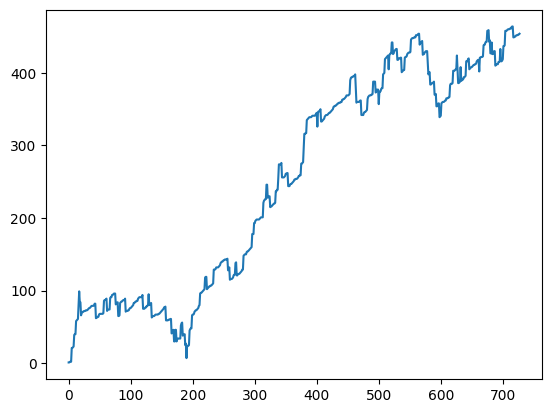

In [319]:
# Generate an increasing number of customers over time with occasional dips
def generate_customer_count_sequence(total_days, total_customers):
    counts = []
    current_count = 0
    for day in range(total_days):
        choice= random.choice(range(10))
        if day % 7 == 0 and day > 0:  # Increase more significantly at the start of each week
            current_count += random.randint(1, 3)
        elif choice==5:
            current_count -= random.randint(15, 20)
        elif choice==3:
            current_count += random.randint(15, 20)
        else:
            current_count += random.randint(0, 1)
        current_count = min(current_count, total_customers)
        if current_count<0:
            current_count=1
        counts.append(current_count)
    return counts

# Generate the customer counts
start_date = date(2023, 1, 2)
end_date = date(2024, 12, 29)
total_days = (end_date - start_date).days + 1
customer_counts = generate_customer_count_sequence(total_days, len(customer_ids))
plt.plot(customer_counts)
print(customer_counts)

In [323]:
# Function to generate random shopping data for a given date
def generate_daily_data(current_date, num_customers):
    week = current_date.isocalendar()[1]
    # print(week)
    random.seed(current_date.toordinal())

    customers_today = random.sample(customer_ids, num_customers)
    data = []
    # customer_weekly_purchase_count = {customer: {} for customer in customer_ids}

    # if previous_week != week:
    #     weekly_purchase_info= {}
    #     for customer_id in customers_today:
    #         weekly_purchase_info[customer_id]= []
    
    for customer_id in customers_today:
        # Ensure customer does not buy more than 50 items per week
        # if len(weekly_purchase_info[customer_id]) >= 50:
        #     continue

        num_items = random.randint(1, 10)
        # store_today = random.choice(store_ids)
        
        for _ in range(num_items):
            product = random.choice(product_ids)

            # weekly_purchase_info[customer_id].append(product)

            # Ensure customer does not buy a product more than 10 times in a week
            # if weekly_purchase_info[customer_id].count(product) >= 10:
            #     continue
                
            purchase_id = generate_uuid()
            data.append((purchase_id, current_date, week, customer_id, product))

    # previous_week= week
    
    return data

In [324]:
# Generate synthetic data for each date
synthetic_data = []
current_date = start_date
index = 0
previous_week=0
while current_date <= end_date:
    daily_data = generate_daily_data(current_date, customer_counts[index])
    synthetic_data.extend(daily_data)
    current_date += timedelta(days=1)
    index += 1

1
1
1
1
1
1
1
2
2
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4
4
4
4
4
5
5
5
5
5
5
5
6
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
8
8
8
8
8
9
9
9
9
9
9
9
10
10
10
10
10
10
10
11
11
11
11
11
11
11
12
12
12
12
12
12
12
13
13
13
13
13
13
13
14
14
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
16
17
17
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
19
20
20
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
22
23
23
23
23
23
23
23
24
24
24
24
24
24
24
25
25
25
25
25
25
25
26
26
26
26
26
26
26
27
27
27
27
27
27
27
28
28
28
28
28
28
28
29
29
29
29
29
29
29
30
30
30
30
30
30
30
31
31
31
31
31
31
31
32
32
32
32
32
32
32
33
33
33
33
33
33
33
34
34
34
34
34
34
34
35
35
35
35
35
35
35
36
36
36
36
36
36
36
37
37
37
37
37
37
37
38
38
38
38
38
38
38
39
39
39
39
39
39
39
40
40
40
40
40
40
40
41
41
41
41
41
41
41
42
42
42
42
42
42
42
43
43
43
43
43
43
43
44
44
44
44
44
44
44
45
45
45
45
45
45
45
46
46
46
46
46
46
46
47
47
47
47
47
47
47
48
48
48
48
48
48
48
49
49
49
49
49
49
49
50
50
50
50
50
50
50
51
51
51
51
5

In [326]:
# Create a Spark DataFrame from the synthetic data
columns = ["purchase_id", "date", "week", "customer_id", "product_id"]
df_time_series = spark.createDataFrame(synthetic_data, columns)
row_count = df_time_series.count()
column_count = len(df_time_series.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_time_series.show(20)

shape of the dataframe= (1002977, 5)
+--------------------+----------+----+-----------+--------------------+
|         purchase_id|      date|week|customer_id|          product_id|
+--------------------+----------+----+-----------+--------------------+
|cf2fe8cc-e35d-418...|2023-01-02|   1|         14|d41c88f5-8b37-424...|
|6fbe61af-9164-42a...|2023-01-02|   1|         14|3990ed4f-2897-49e...|
|3ee9747c-bebc-493...|2023-01-02|   1|         14|d2930337-aacb-423...|
|18fdbc94-acea-43f...|2023-01-02|   1|         14|2cbecb10-238e-424...|
|c8bbd165-e000-411...|2023-01-02|   1|         14|4e2c9e82-96f2-47c...|
|b37961e3-e1a6-4e7...|2023-01-02|   1|         14|05f9d9db-3862-498...|
|b70c29f5-ea17-463...|2023-01-02|   1|         14|ef3ba139-b5a9-449...|
|66928bcd-1b23-4ea...|2023-01-02|   1|         14|a289486c-370f-47c...|
|046dd4e9-a592-438...|2023-01-03|   1|        250|07d3d77d-692b-4dd...|
|82c1e56f-5480-49c...|2023-01-03|   1|        250|dcad8663-0f5a-444...|
|92149a41-e65d-408...|2023-

In [330]:
# merging the customer data with it 
df_ts_merge1= df_time_series.join(df_customer, "customer_id")
df_ts_merge1= df_ts_merge1.select("date", "week", "purchase_id", "customer_id", "product_id", "location_id", "customer_name", "country_code", "postal_code", "place_name", "latitude", "longitude")
row_count = df_ts_merge1.count()
column_count = len(df_ts_merge1.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_ts_merge1.show()

shape of the dataframe= (1002977, 12)
+----------+----+--------------------+-----------+--------------------+-----------+--------------+------------+-----------+----------+--------+---------+
|      date|week|         purchase_id|customer_id|          product_id|location_id| customer_name|country_code|postal_code|place_name|latitude|longitude|
+----------+----+--------------------+-----------+--------------------+-----------+--------------+------------+-----------+----------+--------+---------+
|2023-01-02|   1|cf2fe8cc-e35d-418...|         14|d41c88f5-8b37-424...|      21584|    Eric Jones|          ES|       8610|      Avia| 42.0667|     1.85|
|2023-01-02|   1|6fbe61af-9164-42a...|         14|3990ed4f-2897-49e...|      21584|    Eric Jones|          ES|       8610|      Avia| 42.0667|     1.85|
|2023-01-02|   1|3ee9747c-bebc-493...|         14|d2930337-aacb-423...|      21584|    Eric Jones|          ES|       8610|      Avia| 42.0667|     1.85|
|2023-01-02|   1|18fdbc94-acea-43f...|

In [332]:
# merging it with the supermarket inventory data
df_ts_merge2= df_ts_merge1.join(df_inventory, "product_id")
row_count = df_ts_merge2.count()
column_count = len(df_ts_merge2.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_ts_merge2.show()

shape of the dataframe= (8267635, 18)
+--------------------+----------+----+--------------------+-----------+-----------+-------------+------------+-----------+----------+--------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------+
|          product_id|      date|week|         purchase_id|customer_id|location_id|customer_name|country_code|postal_code|place_name|latitude|longitude|            store_id|          store_name|        product_name|price| product_description|quantity|
+--------------------+----------+----+--------------------+-----------+-----------+-------------+------------+-----------+----------+--------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------+
|d41c88f5-8b37-424...|2023-01-02|   1|cf2fe8cc-e35d-418...|         14|      21584|   Eric Jones|          ES|       8610|      Avia| 42.0667|     1.85| cens-0824440003-296|              CONDIS|          Fl

In [336]:
df_ts= df_ts_merge2.select("date", "week", "purchase_id", "product_id", "store_id", "customer_id", "location_id", "customer_name", "country_code", "postal_code", "place_name", "latitude", "longitude", "store_name", "product_name", "price", "product_description")
row_count = df_ts.count()
column_count = len(df_ts.columns)
print(f"shape of the dataframe= {(row_count, column_count)}")
df_ts.show(500)

shape of the dataframe= (8267635, 17)
+----------+----+--------------------+--------------------+--------------------+-----------+-----------+----------------+------------+-----------+--------------------+--------+---------+--------------------+--------------------+-----+--------------------+
|      date|week|         purchase_id|          product_id|            store_id|customer_id|location_id|   customer_name|country_code|postal_code|          place_name|latitude|longitude|          store_name|        product_name|price| product_description|
+----------+----+--------------------+--------------------+--------------------+-----------+-----------+----------------+------------+-----------+--------------------+--------+---------+--------------------+--------------------+-----+--------------------+
|2023-01-02|   1|cf2fe8cc-e35d-418...|d41c88f5-8b37-424...| cens-0824440003-296|         14|      21584|      Eric Jones|          ES|       8610|                Avia| 42.0667|     1.85|        

In [338]:
# output to a parquet file
output_path = "./parquet_files/purchases_time_series"
df_ts.write.mode('overwrite').parquet(output_path)

In [339]:
# time series data generated

In [340]:
# now lets work on the projection 

In [341]:
# refer to the next notebook